<a href="https://colab.research.google.com/github/denis201520182022/colorization-project/blob/new-model/colorize_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from skimage import color



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from skimage import color
from skimage.color import lab2rgb
from skimage.color import rgb2lab


class CIFAR10_Lab(Dataset):
  def __init__(self, train=True):
    self.data = CIFAR10(root='./data', train=train, download=True)
    self.images = self.data.data

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_rgb = self.images[idx]/255.0
    img_lab = color.rgb2lab(img_rgb)

    L = img_lab[:,:, 0] / 100.0
    ab = img_lab[:,:, 1:] / 128.0

    L_tenzor = torch.tensor(L, dtype=torch.float32).unsqueeze(0)
    ab_tenzor = torch.tensor(ab, dtype=torch.float32).permute(2,0,1)

    return L_tenzor, ab_tenzor

In [10]:
train_dataset = CIFAR10_Lab(train=True)
test_dataset = CIFAR10_Lab(train=False)

train_loader =DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32)

Тип L: <class 'torch.Tensor'>  | Форма: torch.Size([1, 32, 32])
Тип ab: <class 'torch.Tensor'>  | Форма: torch.Size([2, 32, 32])
L_np: (32, 32)
ab_np (до транспонирования): (2, 32, 32)
ab_np (после): (32, 32, 2)


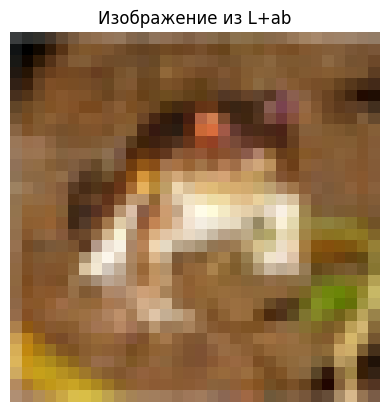

In [11]:
L, ab = train_dataset[0]

print("Тип L:", type(L), " | Форма:", L.shape)
print("Тип ab:", type(ab), " | Форма:", ab.shape)

L_np = L.squeeze().numpy() * 100
ab_np = ab.numpy() * 128

print("L_np:", L_np.shape)
print("ab_np (до транспонирования):", ab_np.shape)

ab_np = ab_np.transpose(1, 2, 0)
print("ab_np (после):", ab_np.shape)

lab_img = np.zeros((32, 32, 3), dtype=np.float32)
lab_img[:, :, 0] = L_np
lab_img[:, :, 1:] = ab_np

rgb_img = lab2rgb(lab_img)

plt.imshow(rgb_img)
plt.axis('off')
plt.title("Изображение из L+ab")
plt.show()


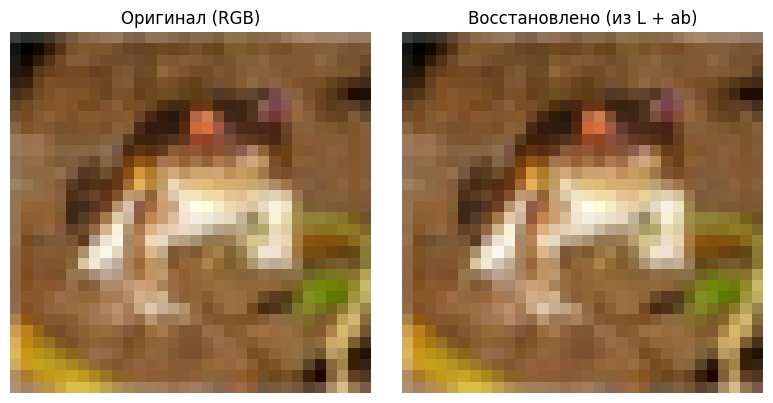

In [12]:
import matplotlib.pyplot as plt
original_img = train_dataset.data.data[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(original_img)
axs[0].set_title("Оригинал (RGB)")
axs[0].axis('off')

axs[1].imshow(rgb_img)
axs[1].set_title("Восстановлено (из L + ab)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [9]:
import torch
import torch.nn as nn

class SuperColorizationNet(nn.Module):
    def __init__(self):
        super(SuperColorizationNet, self).__init__()

        # --------- Encoder ---------
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # MaxPooling
        self.pool = nn.MaxPool2d(2, 2)

        # --------- Decoder ---------
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)  # 128 (up) + 128 (skip)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)  # 64 (up) + 64 (skip)

        # Выход
        self.final_conv = nn.Conv2d(64, 2, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)  # (64,32,32)
        p1 = self.pool(e1) # (64,16,16)

        e2 = self.enc2(p1) # (128,16,16)
        p2 = self.pool(e2) # (128,8,8)

        e3 = self.enc3(p2) # (256,8,8)

        # Decoder
        d2 = self.upconv2(e3) # (128,16,16)
        d2 = torch.cat([d2, e2], dim=1) # concat skip connection
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2) # (64,32,32)
        d1 = torch.cat([d1, e1], dim=1) # concat skip connection
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        out = self.tanh(out)
        return out


In [16]:
learning_rate = 1e-3
num_epochs = 50
model = SuperColorizationNet().to(device)

#model.load_state_dict(torch.load('colorization_weights.pth'))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer.load_state_dict(torch.load('optimizer_weights.pth'))
criterion = nn.MSELoss()

In [15]:
fixed_L, fixed_ab = train_dataset[0]
fixed_L = fixed_L.unsqueeze(0).to(device)

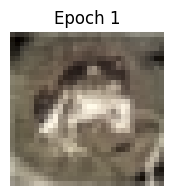

Эпоха 1/50, Потеря: 0.011522


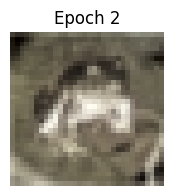

Эпоха 2/50, Потеря: 0.009532


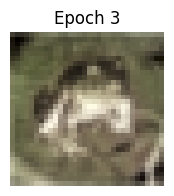

Эпоха 3/50, Потеря: 0.009312


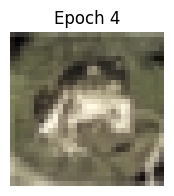

Эпоха 4/50, Потеря: 0.009169


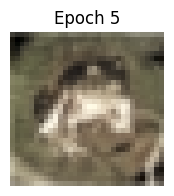

Эпоха 5/50, Потеря: 0.009054


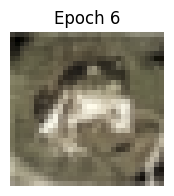

Эпоха 6/50, Потеря: 0.008964


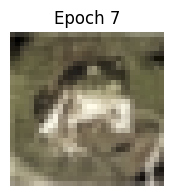

Эпоха 7/50, Потеря: 0.008867


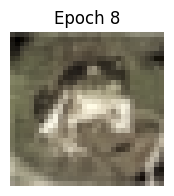

Эпоха 8/50, Потеря: 0.008765


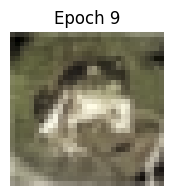

Эпоха 9/50, Потеря: 0.008713


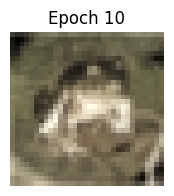

Эпоха 10/50, Потеря: 0.008620


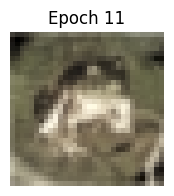

Эпоха 11/50, Потеря: 0.008564


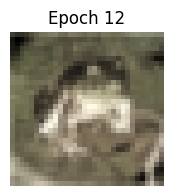

Эпоха 12/50, Потеря: 0.008495


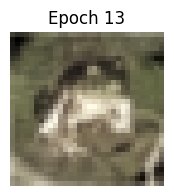

Эпоха 13/50, Потеря: 0.008442


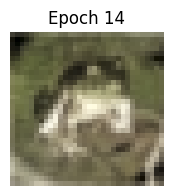

Эпоха 14/50, Потеря: 0.008360


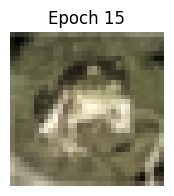

Эпоха 15/50, Потеря: 0.008297


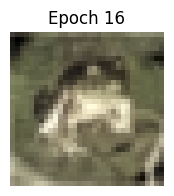

Эпоха 16/50, Потеря: 0.008237


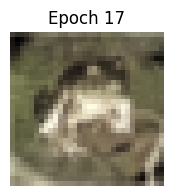

Эпоха 17/50, Потеря: 0.008193


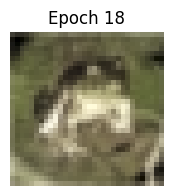

Эпоха 18/50, Потеря: 0.008115


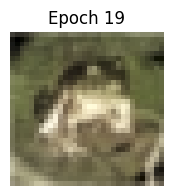

Эпоха 19/50, Потеря: 0.008054


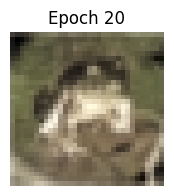

Эпоха 20/50, Потеря: 0.007986


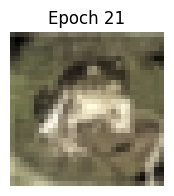

Эпоха 21/50, Потеря: 0.007927


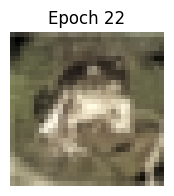

Эпоха 22/50, Потеря: 0.007865


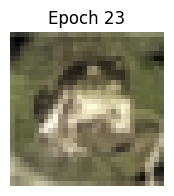

Эпоха 23/50, Потеря: 0.007830


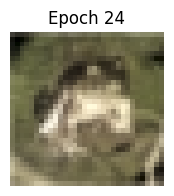

Эпоха 24/50, Потеря: 0.007769


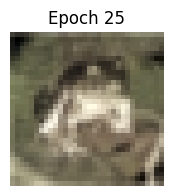

Эпоха 25/50, Потеря: 0.007699


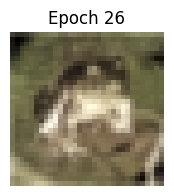

Эпоха 26/50, Потеря: 0.007654


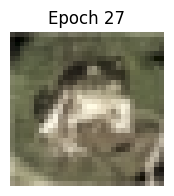

Эпоха 27/50, Потеря: 0.007585


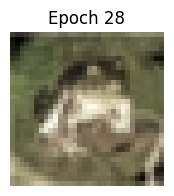

Эпоха 28/50, Потеря: 0.007508


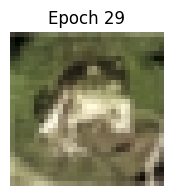

Эпоха 29/50, Потеря: 0.007455


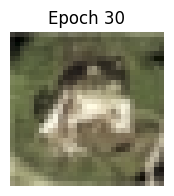

Эпоха 30/50, Потеря: 0.007434


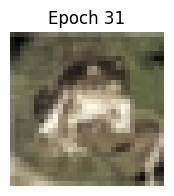

Эпоха 31/50, Потеря: 0.007356


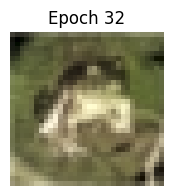

Эпоха 32/50, Потеря: 0.007296


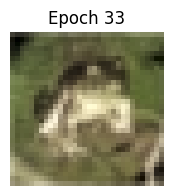

Эпоха 33/50, Потеря: 0.007232


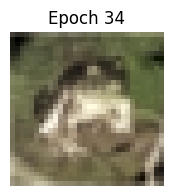

Эпоха 34/50, Потеря: 0.007173


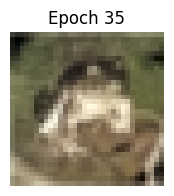

Эпоха 35/50, Потеря: 0.007115


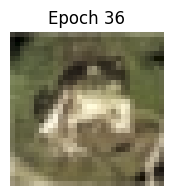

Эпоха 36/50, Потеря: 0.007072


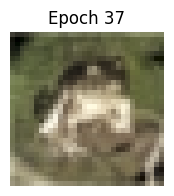

Эпоха 37/50, Потеря: 0.007014


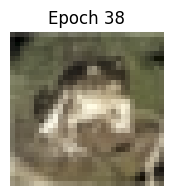

Эпоха 38/50, Потеря: 0.006947


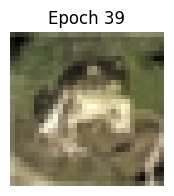

Эпоха 39/50, Потеря: 0.006906


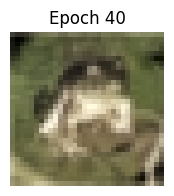

Эпоха 40/50, Потеря: 0.006849


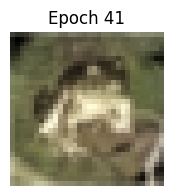

Эпоха 41/50, Потеря: 0.006806


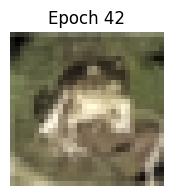

Эпоха 42/50, Потеря: 0.006755


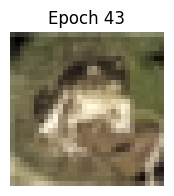

Эпоха 43/50, Потеря: 0.006709


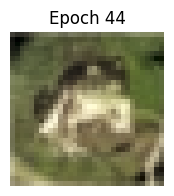

Эпоха 44/50, Потеря: 0.006637


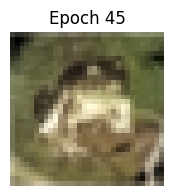

Эпоха 45/50, Потеря: 0.006622


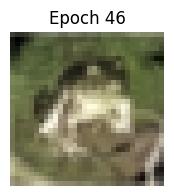

Эпоха 46/50, Потеря: 0.006543


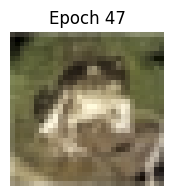

Эпоха 47/50, Потеря: 0.006508


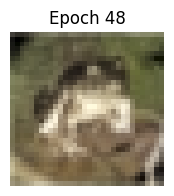

Эпоха 48/50, Потеря: 0.006482


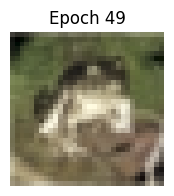

Эпоха 49/50, Потеря: 0.006418


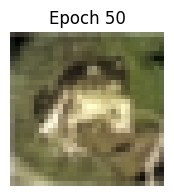

Эпоха 50/50, Потеря: 0.006386


In [17]:
from tqdm import tqdm


for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  loop = tqdm(train_loader, desc=f"Эпоха [{epoch+1}/{num_epochs}]", leave=False)
  for L, ab in loop:

    L, ab = L.to(device), ab.to(device)
    optimizer.zero_grad()
    output = model(L)
    loss = criterion(output, ab)


    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    loop.set_postfix(loss=loss.item())

  model.eval()  # Переводим модель в режим оценки (без обучения)
  with torch.no_grad():  # Не считаем градиенты, чтобы сэкономить память
    output_ab = model(fixed_L)  # Предсказание ab-каналов


  L_np = fixed_L.squeeze(0).squeeze(0).cpu().numpy() * 100  # (32,32)
  ab_np = output_ab.squeeze(0).cpu().numpy() * 128  # (2,32,32)
  ab_np = ab_np.transpose(1, 2, 0)  # (32,32,2)

  # Собираем обратно LAB картинку
  lab_img = np.zeros((32, 32, 3), dtype=np.float32)
  lab_img[:, :, 0] = L_np
  lab_img[:, :, 1:] = ab_np

  # Переводим LAB -> RGB
  rgb_img = lab2rgb(lab_img)

  # Рисуем
  plt.figure(figsize=(2, 2))
  plt.imshow(rgb_img)
  plt.title(f"Epoch {epoch+1}")
  plt.axis('off')
  plt.show()
  avg_loss = running_loss / len(train_loader)
  print(f"Эпоха {epoch+1}/{num_epochs}, Потеря: {avg_loss:.6f}")


In [18]:
torch.save(model.state_dict(), "colorization_weights.pth")
print("Модель сохранена как 'colorization_weights.pth'")

Модель сохранена как 'colorization_weights.pth'


In [19]:
test_dataset = CIFAR10_Lab(train=False)  # Указываем, что это тестовые данные
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

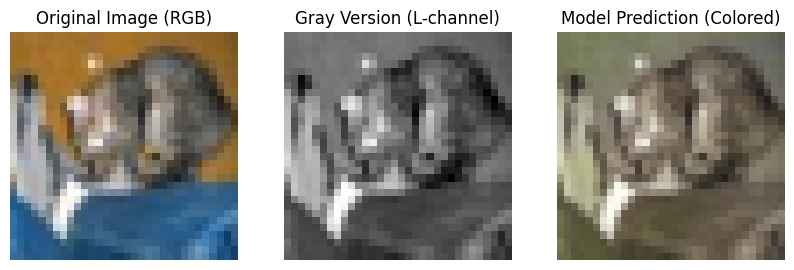

Pixel Accuracy: 0.0135
SSIM: 0.7299
PSNR: 22.6112
MSE: 132.7604


In [55]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# Функция для вычисления Pixel Accuracy
def pixel_accuracy(predicted, ground_truth, threshold=0.1):
    """
    Вычисляет точность пикселей: насколько предсказания близки к истинным.
    """
    diff = np.abs(predicted - ground_truth)
    correct = np.sum(diff < threshold)
    total = np.prod(ground_truth.shape)  # Общее количество пикселей
    return correct / total

# Функция для вычисления MSE
def mean_squared_error(predicted, ground_truth):
    """
    Вычисляет среднеквадратическую ошибку (MSE) между предсказанными и истинными значениями.
    """
    return np.mean((predicted - ground_truth) ** 2)

# Функция для тестирования модели
import matplotlib.pyplot as plt
import numpy as np

# Функция для тестирования модели с визуализацией трех изображений
def test_model_with_visualization(model, test_loader, device):
    model.eval()  # Переводим модель в режим оценки (без обучения)

    pixel_acc_list = []
    ssim_list = []
    psnr_list = []
    mse_list = []

    with torch.no_grad():  # Не считаем градиенты, чтобы сэкономить память
        for L, ab in test_loader:
            L, ab = L.to(device), ab.to(device)

            # Предсказание ab-каналов
            output_ab = model(L)

            # Преобразуем тензоры в numpy массивы для метрик
            output_ab = output_ab.squeeze(0).cpu().numpy() * 128  # Преобразуем в диапазон от -128 до 128
            ab_np = ab.squeeze(0).cpu().numpy() * 128  # Истинные значения для сравнения


            single_output_ab = output_ab[0]  # Берём первое изображение из батча

            single_ab_np = ab_np[0]

            single_L = L[0]

            # Переводим аб-каналы в (32, 32, 2) для оценки
            ab_pred = single_output_ab.transpose(1, 2, 0)
            ab_true = single_ab_np.transpose(1, 2, 0)

            # Визуализируем результаты (три изображения)
            if len(pixel_acc_list) == 0:  # Визуализируем только первый пример
                L_np = single_L.squeeze(0).cpu().numpy() * 100  # Л-канал изображения

                # Собираем обратно LAB картинку для предсказанного изображения
                lab_img_pred = np.zeros((32, 32, 3), dtype=np.float32)
                lab_img_pred[:, :, 0] = L_np
                lab_img_pred[:, :, 1:] = ab_pred
                rgb_img_pred = lab2rgb(lab_img_pred)

                # Собираем обратно LAB картинку для истинного изображения
                lab_img_true = np.zeros((32, 32, 3), dtype=np.float32)
                lab_img_true[:, :, 0] = L_np
                lab_img_true[:, :, 1:] = ab_true
                rgb_img_true = lab2rgb(lab_img_true)

                # Визуализируем три изображения
                plt.figure(figsize=(10, 5))

                # Оригинальное изображение (в цвете)
                plt.subplot(1, 3, 1)
                plt.imshow(lab2rgb(np.concatenate([L_np[..., np.newaxis], ab_true], axis=-1)))
                plt.title("Original Image (RGB)")
                plt.axis('off')

                # Серая версия (L-канал)
                plt.subplot(1, 3, 2)
                plt.imshow(L_np, cmap='gray')
                plt.title("Gray Version (L-channel)")
                plt.axis('off')

                # Раскрашенная версия (предсказание модели)
                plt.subplot(1, 3, 3)
                plt.imshow(rgb_img_pred)
                plt.title("Model Prediction (Colored)")
                plt.axis('off')

                plt.show()

            # Оценка Pixel Accuracy
            pixel_acc = pixel_accuracy(ab_pred, ab_true)
            pixel_acc_list.append(pixel_acc)

            # Оценка SSIM
            ssim_value = ssim(lab_img_pred, lab_img_true, multichannel=True, win_size=3, data_range=128)

            ssim_list.append(ssim_value)

            # Оценка PSNR
            psnr_value = psnr(ab_true, ab_pred, data_range=128)
            psnr_list.append(psnr_value)

            # Оценка MSE
            mse_value = mean_squared_error(ab_pred, ab_true)
            mse_list.append(mse_value)

    # Среднее значение метрик
    avg_pixel_acc = np.mean(pixel_acc_list)
    avg_ssim = np.mean(ssim_list)
    avg_psnr = np.mean(psnr_list)
    avg_mse = np.mean(mse_list)

    return avg_pixel_acc, avg_ssim, avg_psnr, avg_mse

# Пример использования
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# test_loader - это DataLoader для тестового набора данных

pixel_acc, ssim_val, psnr_val, mse_val = test_model_with_visualization(model, test_loader, device)

print(f"Pixel Accuracy: {pixel_acc:.4f}")
print(f"SSIM: {ssim_val:.4f}")
print(f"PSNR: {psnr_val:.4f}")
print(f"MSE: {mse_val:.4f}")


In [56]:
from google.colab import files


torch.save(model, "colorization_model.pth")
torch.save(optimizer.state_dict(), 'optimizer_weights.pth')

files.download("colorization_weights.pth")
files.download("colorization_model.pth")
files.download("optimizer_weights.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

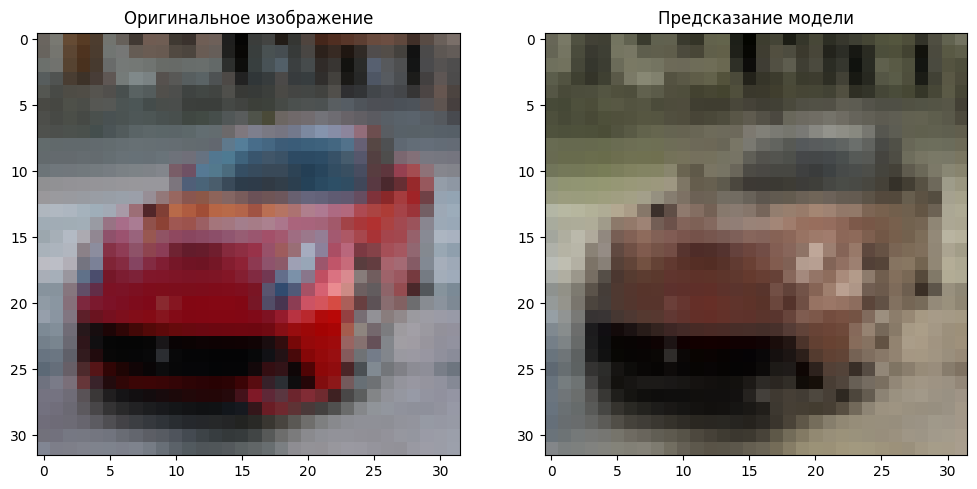

In [57]:
import torch
import requests
from PIL import Image
import numpy as np
from torchvision import transforms
from skimage import color
import matplotlib.pyplot as plt

# Загрузка изображения с интернета
image_url = "https://www.1zoom.me/big2/819/321881-svetik.jpg"  # Замените на актуальную ссылку
response = requests.get(image_url, stream=True)
img = Image.open(response.raw)

# Предобработка изображения
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Размер, соответствующий входу модели
    transforms.ToTensor(),  # Перевод в тензор
])

img_tensor = transform(img).unsqueeze(0)  # Добавляем дополнительную ось для батча (1, C, H, W)

# Преобразуем в цветовое пространство Lab
img_rgb = img_tensor.squeeze().numpy().transpose(1, 2, 0)  # Преобразуем обратно в numpy array
img_lab = color.rgb2lab(img_rgb)  # Преобразуем в Lab

L = img_lab[:, :, 0] / 100.0  # Канал L (светлота)
ab = img_lab[:, :, 1:] / 128.0  # Каналы a и b

# Перемещаем данные на нужное устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразуем данные в тензоры
L_tensor = torch.tensor(L, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)
ab_tensor = torch.tensor(ab, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)  # (1, 2, H, W)

# Перемещаем модель на тот же девайс
model.to(device)
model.eval()  # Переводим модель в режим оценки

# Прогоняем изображение через модель
with torch.no_grad():  # Отключаем вычисление градиентов
    output = model(L_tensor)  # Получаем предсказание модели

# Визуализация
output = output.squeeze().permute(1, 2, 0).cpu().numpy()  # Переводим результат в numpy для визуализации

# Собираем Lab и конвертируем в RGB
ab_pred = output * 128.0  # Каналы a, b в диапазоне [-128, 128]
L_pred = L * 100.0  # Канал L в диапазоне [0, 100]

lab_pred = np.concatenate([L_pred[..., np.newaxis], ab_pred], axis=-1)
rgb_pred = color.lab2rgb(lab_pred)

# Визуализируем
plt.figure(figsize=(12, 6))

# Оригинал
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Оригинальное изображение")

# Результат модели
plt.subplot(1, 2, 2)
plt.imshow(rgb_pred)
plt.title("Предсказание модели")

plt.show()
